# Imports

In [1]:
from collections import Counter
import os
import sys

from keras.models import Model
from keras.layers import Input, CuDNNLSTM, Dense, Dropout
from keras.regularizers import l2
from keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13985897789497635417
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 245563392
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14534041904249477236
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


# Config

In [3]:
STORIES_DIR = 'data/cnn/stories/'
story_files = os.listdir(STORIES_DIR)

In [4]:
n_files = len(story_files)
print('Stories in directory: %d' % n_files)

Stories in directory: 92579


In [5]:
characters = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
    'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
    'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '.', '?', '!',
    ' ', '-', "'", '"', ':', ';', '/', '%', '&', '$', '€', '£', '@',
    '#', '*', '+', '=', '^', '(', ')', '[', ']', '{', '}', '<', '>',
    '_', '~', '|', '\t', '\n'
]

In [6]:
n_characters = len(characters)
n_characters

96

In [7]:
STORIES_TO_PARSE = 75000
MAX_STORY_CHARS_TO_CONSIDER = 1500
MAX_SUMMARY_CHARS_TO_CONSIDER = 250
LSTM_LATENT_DIM = 512
BATCH_SIZE = 50
EPOCHS = 100
BATCHES_PER_LOSSCALC = 10

# Generate Char Dicts

In [8]:
%%time
idx_2_char = {}
char_2_idx = {}
for i, char in enumerate(characters):
    idx_2_char[i] = char
    char_2_idx[char] = i
    

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 67.5 µs


# Configure NNs

## Training

In [9]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, n_characters))
encoder = CuDNNLSTM(
    units=LSTM_LATENT_DIM, 
    return_state=True
)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
state_h = Dropout(0.5)(state_h)
state_c = Dropout(0.5)(state_c)
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, n_characters))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = CuDNNLSTM(
    units=LSTM_LATENT_DIM, 
    return_sequences=True, 
    return_state=True
)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_outputs = Dropout(0.5)(decoder_outputs)
decoder_dense = Dense(
    units=n_characters, 
    activation='softmax'
)
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [10]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [11]:
# summarize layers
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 96)     0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 512), (None, 1249280     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 96)     0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512)          0           cu_dnnlstm_1[0][1]               
__________________________________________________________________________________________________
dropout_2 

In [12]:
# plot graph
plot_model(model, to_file='seq2seq_char_shallow_dropout.png')

## Inference

In [13]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(LSTM_LATENT_DIM,))
decoder_state_input_c = Input(shape=(LSTM_LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [14]:
def get_summary(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, n_characters))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, char_2_idx['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    iterations = 0
    decoded_sentence = ''
    while not stop_condition:
        iterations += 1
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value
        )

        # Sample a token
        sampled_char_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx_2_char[sampled_char_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
            iterations == MAX_SUMMARY_CHARS_TO_CONSIDER):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, n_characters))
        target_seq[0, 0, sampled_char_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [15]:
# summarize layers
print(encoder_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 96)     0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 512), (None, 1249280     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512)          0           cu_dnnlstm_1[0][1]               
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 512)          0           cu_dnnlstm_1[0][2]               
Total params: 1,249,280
Trainable params: 1,249,280
Non-trainable params: 0
_________________________________

In [16]:
# plot graph
plot_model(encoder_model, to_file='seq2seq_char_shallow_dropout_inference_encoder.png')

In [17]:
# summarize layers
print(decoder_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, 96)     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)        [(None, None, 512),  1249280     input_2[0][0]                    
                                                                 input_3[0][0]                    
          

In [18]:
# plot graph
plot_model(decoder_model, to_file='seq2seq_char_shallow_dropout_inference_decoder.png')

# Model Training


Epoch 0:


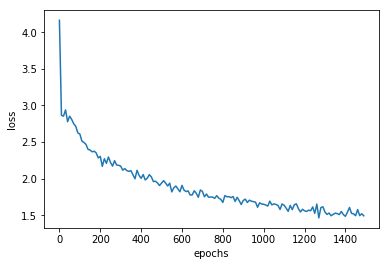




Story:
DEKALB, Illinois  -- Eric Mace says he thought he was giving his daughter good advice by asking her to sit up front in class.  Ryanne Mace was 19 when she was killed last year in a shooting rampage at Northern Illinois University.  "I'd like you to sit in the front row of every class that you're in and constantly drag information out of these people, and if you don't understand what they're talking about, raise your hand and say, 'I don't get it' until you get it," Mace recalled telling her.  His daughter, 19-year-old Ryanne, took that advice. Now, he wishes she would have sat somewhere else.  Mace believes that Ryanne was probably one of the first to be killed in the Northern Illinois University shootings a year ago, because she was in the front row in the lecture at Cole Hall.  "She was, from what I understand, in the front row of that room and was probably the first one that had shots fired at her after the gentleman that was on stage," Mace said.  "It's not an easy thing 

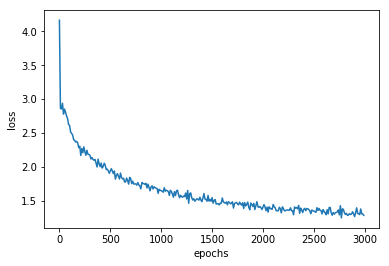




Story:
DEKALB, Illinois  -- Eric Mace says he thought he was giving his daughter good advice by asking her to sit up front in class.  Ryanne Mace was 19 when she was killed last year in a shooting rampage at Northern Illinois University.  "I'd like you to sit in the front row of every class that you're in and constantly drag information out of these people, and if you don't understand what they're talking about, raise your hand and say, 'I don't get it' until you get it," Mace recalled telling her.  His daughter, 19-year-old Ryanne, took that advice. Now, he wishes she would have sat somewhere else.  Mace believes that Ryanne was probably one of the first to be killed in the Northern Illinois University shootings a year ago, because she was in the front row in the lecture at Cole Hall.  "She was, from what I understand, in the front row of that room and was probably the first one that had shots fired at her after the gentleman that was on stage," Mace said.  "It's not an easy thing 

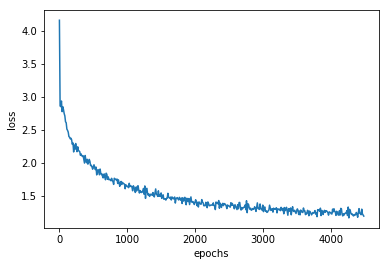




Story:
DEKALB, Illinois  -- Eric Mace says he thought he was giving his daughter good advice by asking her to sit up front in class.  Ryanne Mace was 19 when she was killed last year in a shooting rampage at Northern Illinois University.  "I'd like you to sit in the front row of every class that you're in and constantly drag information out of these people, and if you don't understand what they're talking about, raise your hand and say, 'I don't get it' until you get it," Mace recalled telling her.  His daughter, 19-year-old Ryanne, took that advice. Now, he wishes she would have sat somewhere else.  Mace believes that Ryanne was probably one of the first to be killed in the Northern Illinois University shootings a year ago, because she was in the front row in the lecture at Cole Hall.  "She was, from what I understand, in the front row of that room and was probably the first one that had shots fired at her after the gentleman that was on stage," Mace said.  "It's not an easy thing 

In [ ]:
batch = 0
batches = []
losses = []
for epoch in np.arange(EPOCHS):
    print('\nEpoch %d:' % epoch)
    for start_file_idx in tqdm_notebook(np.arange(0, STORIES_TO_PARSE, BATCH_SIZE)):
        end_file_idx = min(start_file_idx+BATCH_SIZE, STORIES_TO_PARSE)

        # get story and summary strings
        stories = []
        summaries = []
        for filename in story_files[start_file_idx:end_file_idx]:
            f = open(STORIES_DIR+filename, 'r')
            combo = f.read()
            splt = combo.split('@highlight')

            story = splt[0].replace('(CNN)', '').replace('\n', ' ')
            stories.append(story)

            summary = '. '.join(splt[1:]).replace('\n', '')
            summary = '\t ' + summary + ' \n'
            summaries.append(summary)

            f.close()
        N = len(stories)

        # embed stories
        stories_embeddings = np.zeros(
            (N, MAX_STORY_CHARS_TO_CONSIDER, n_characters),
            dtype='float32'
        )
        for i, story in enumerate(stories):
            for j, char in enumerate(story):
                if j < MAX_STORY_CHARS_TO_CONSIDER:
                    if char in char_2_idx:
                        k = char_2_idx[char]
                        stories_embeddings[i, j, k] = 1.
                else:
                    break        
        
        # embed summaries
        summaries_embeddings_input = np.zeros(
            (N, MAX_SUMMARY_CHARS_TO_CONSIDER, n_characters),
            dtype='float32'
        )   
        summaries_embeddings_target = np.zeros(
            (N, MAX_SUMMARY_CHARS_TO_CONSIDER, n_characters),
            dtype='float32'
        )
        for i, summary in enumerate(summaries):
            for j, char in enumerate(summary):
                if j <= MAX_SUMMARY_CHARS_TO_CONSIDER:
                    if char in char_2_idx:
                        k = char_2_idx[char]
                        if j < MAX_SUMMARY_CHARS_TO_CONSIDER:
                            summaries_embeddings_input[i, j, k] = 1.
                        if j > 0:
                            summaries_embeddings_target[i, j-1, k] = 1.
                else:
                    break

        # update model
        model.train_on_batch([stories_embeddings, summaries_embeddings_input], summaries_embeddings_target)
        if (batch % BATCHES_PER_LOSSCALC) == 0:
            batches.append(batch)
            loss = model.test_on_batch([stories_embeddings, summaries_embeddings_input], summaries_embeddings_target)
            losses.append(loss)
        batch += 1
    
    # spot check performance
    plt.plot(batches, losses)
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.show()
    plt.close()
    
    for i in np.arange(2):
        to_summarize = stories_embeddings[i].reshape(1, MAX_STORY_CHARS_TO_CONSIDER, n_characters)
        generated_summary = get_summary(to_summarize)
        print('\n\n')
        print('Story:')
        print(stories[i])
        print('\nActual Summary:')
        print(summaries[i])
        print('\nGenerated Summary:')
        print(generated_summary)

^note: generated summaries weren't actually blank here...just forgot to include print(generated_summary)

## Spot Check Performance

In [ ]:
for i in range(5):
    to_summarize = stories_embeddings[i].reshape(1, MAX_STORY_CHARS_TO_CONSIDER, n_characters)
    generated_summary = get_summary(to_summarize)
    print('\n\n')
    print('Story:')
    print(stories[i])
    print('\nActual Summary:')
    print(summaries[i])
    print('\nGenerated Summary:')
    print(generated_summary)

# Graveyard